## Fine tune GPT complete task

In [1]:
import sys, os, openai
import pandas as pd
from unidecode import unidecode
from sklearn.model_selection import train_test_split
sys.path.insert(1, '../')
from auth import auth
os.environ['OPENAI_API_KEY'] = auth.SECRET_KEY
openai.api_key = auth.SECRET_KEY

### Data

In [2]:
DATA_PATH = '../data/essays/'

essays = list()
annotations = list()

for f in os.listdir(DATA_PATH):
    if f.endswith('.txt'):
        essays.append(f)
    elif f.endswith('.ann'):
        annotations.append(f)

essays.sort()
annotations.sort()

print(f'''
Number of essays: {len(essays)}
Number of annotations: {len(annotations)}
''')


Number of essays: 402
Number of annotations: 402



In [3]:
data = list()

for i in range(len(essays)):
    with open(DATA_PATH+essays[i], 'r') as e:
        prompt = e.read()
    with open(DATA_PATH+annotations[i], 'r') as a:
        completion = a.read()
    data.append((prompt, completion))

data_df = pd.DataFrame(columns=['prompt', 'completion'], data=data)
data_df.shape

(402, 2)

In [4]:
data_df.head()

,prompt,completion
0,Should students be taught to compete or to coo...,T1\tMajorClaim 503 575\twe should attach more ...
1,More people are migrating to other countries t...,T1\tMajorClaim 391 489\tthey are able to susta...
2,International tourism is now more common than ...,T1\tMajorClaim 352 475\tit has contributed to ...
3,International tourism is now more common than ...,T1\tMajorClaim 262 376\tthis industry has affe...
4,Living and studying overseas\n\nIt is every st...,T1\tMajorClaim 286 359\tone who studies overse...


In [5]:
data_df['prompt'] = data_df['prompt'].apply(lambda x: unidecode('Analyse the following essay:\n\n'+x.rstrip()+'\n\n###\n\n'))
data_df['completion'] = data_df['completion'].apply(lambda x: unidecode(' '+x.rstrip()+' END'))

data_df.head()

,prompt,completion
0,Analyse the following essay:\n\nShould student...,T1\tMajorClaim 503 575\twe should attach more...
1,Analyse the following essay:\n\nMore people ar...,T1\tMajorClaim 391 489\tthey are able to sust...
2,Analyse the following essay:\n\nInternational ...,T1\tMajorClaim 352 475\tit has contributed to...
3,Analyse the following essay:\n\nInternational ...,T1\tMajorClaim 262 376\tthis industry has aff...
4,Analyse the following essay:\n\nLiving and stu...,T1\tMajorClaim 286 359\tone who studies overs...


In [6]:
print(data_df['prompt'][0])

Analyse the following essay:

Should students be taught to compete or to cooperate?

It is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that we should attach more importance to cooperation during primary education.
First of all, through cooperation, children can learn about interpersonal skills which are significant in the future life of all students. What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others. During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate w

In [6]:
data_df['prompt'][0]

"Analyse the following essay:\n\nShould students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that we should attach more importance to cooperation during primary education.\nFirst of all, through cooperation, children can learn about interpersonal skills which are significant in the future life of all students. What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others. During the process of cooperation, children can learn about how to listen to opinions of others, how to communi

In [7]:
print(data_df['completion'][0])

 T1	MajorClaim 503 575	we should attach more importance to cooperation during primary education
T2	MajorClaim 2154 2231	a more cooperative attitudes towards life is more profitable in one's success
T3	Claim 591 714	through cooperation, children can learn about interpersonal skills which are significant in the future life of all students
A1	Stance T3 For
T4	Premise 716 851	What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others
T5	Premise 853 1086	During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurred
T6	Premise 1088 1191	All of these skills help them to get on well with other people and will benefit them for the whole life
R1	supports Arg1:T4 Arg2:T3	
R2	supports Arg1:T5 Arg2:T3	
R3	supports Arg1:T6 Arg2:T3	
T7	Claim 1332 1376	comp

In [8]:
train, test = train_test_split(data_df, test_size=0.2)

In [9]:
train[['prompt', 'completion']].to_json('../data/proc_data/train_data-complete_task.jsonl', orient='records', lines=True)
test[['prompt', 'completion']].to_json('../data/proc_data/test_data-complete_task.jsonl', orient='records', lines=True)

In [10]:
from nltk.tokenize import word_tokenize

prompt_tokens = pd.Series([len(word_tokenize(prompt)) for prompt in data_df['prompt'].to_list()])
completion_tokens = pd.Series([len(word_tokenize(completion)) for completion in data_df['completion'].to_list()])

<Axes: >

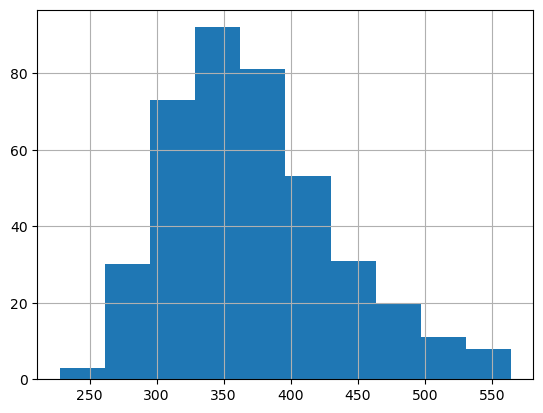

In [11]:
prompt_tokens.hist()

<Axes: >

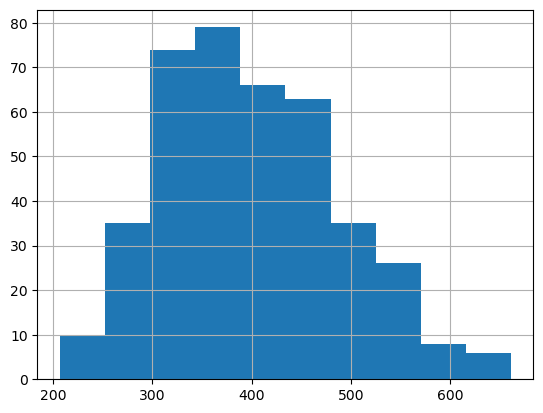

In [12]:
completion_tokens.hist()

In [13]:
print(f'''
Max amount of tokens:

    Prompts: {prompt_tokens.max()}
    Completions: {completion_tokens.max()}
''')


Max amount of tokens:

    Prompts: 564
    Completions: 661



### GPT Fine Tune

In [16]:
!openai api fine_tunes.create -t "../data/proc_data/train_data-complete_task.jsonl" -m babbage --suffix "babbage-ft"

Upload progress: 100%|████████████████████| 1.35M/1.35M [00:00<00:00, 4.13Git/s]
Uploaded file from ../data/proc_data/train_data-complete_task.jsonl: file-SGieU4CbX56BGyeNdcmL2GYX
Created fine-tune: ft-nHRo4jzvTNd4KT2X1EJim9Un
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-04-10 13:50:35] Created fine-tune: ft-nHRo4jzvTNd4KT2X1EJim9Un

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-nHRo4jzvTNd4KT2X1EJim9Un



In [23]:
! openai api fine_tunes.follow -i ft-nHRo4jzvTNd4KT2X1EJim9Un

[2023-04-10 13:50:35] Created fine-tune: ft-nHRo4jzvTNd4KT2X1EJim9Un
[2023-04-10 13:52:37] Fine-tune costs $0.77
[2023-04-10 13:52:38] Fine-tune enqueued. Queue number: 0
[2023-04-10 13:52:43] Fine-tune started
[2023-04-10 13:54:24] Completed epoch 1/4
[2023-04-10 13:55:45] Completed epoch 2/4
[2023-04-10 13:57:06] Completed epoch 3/4
[2023-04-10 13:58:27] Completed epoch 4/4
[2023-04-10 13:58:48] Uploaded model: babbage:ft-hackfest-gpt:babbage-ft-2023-04-10-16-58-48
[2023-04-10 13:58:49] Uploaded result file: file-MQRjfclafLmnxRtl2Zl4vp3t
[2023-04-10 13:58:49] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m babbage:ft-hackfest-gpt:babbage-ft-2023-04-10-16-58-48 -p <YOUR_PROMPT>


### Testing Model

In [37]:
#prompt = test.sample()['prompt'].values[0]
prompt = test['prompt'].values[0]

In [38]:
model = 'babbage:ft-hackfest-gpt:babbage-ft-2023-04-10-16-58-48'

In [39]:
response = openai.Completion.create(
    model=model,
    prompt=prompt,
    temperature=0,
    max_tokens=700
)

In [40]:
print(response['choices'][0].text)

 T1	MajorClaim 459 521	human needs for farmland, housing and industry are more important
T2	MajorClaim 2192 2329	human needs for farmland, housing and industry are more important
T3	Claim 2193 2299	protecting endangered animals is necessary
A1	Stance T3 Against
T4	Claim 2331 2414	human needs for farmland, housing and industry are more important
A2	Stance T4 For
T5	Premise 2428 2486	we can invent new technique to help endangered animals to produce offspring to be sure they would not distinct
T6	Claim 533 607	land used for farmland, housing and industry can benefit more to the whole society
A3	Stance T6 For
T7	Premise 609 740	There is no deny that the economy of the whole society will be developed with the help of agriculture, real estate industry and industry, in particularly industry which is the pillar industry of national economy
T8	Premise 742 837	they produce plenty of profits
T9	Premise 839 923	What is more, the society will be stable and harmony due to more farmland and industry


In [41]:
print(test['completion'].values[0])

 T1	MajorClaim 398 463	human needs for farmland, housing and industry are more important
T2	Claim 2121 2163	protecting endangered animals is necessary
A1	Stance T2 Against
T3	MajorClaim 2179 2244	human needs for farmland, housing and industry are more important
T4	Premise 520 602	land used for farmland, housing and industry can benefit more to the whole society
T5	Premise 626 815	the economy of the whole society will be developed with the help of agriculture, real estate industry and industry, in particularly industry which is the pillar industry of national economy
T6	Premise 825 855	they produce plenty of profits
R1	supports Arg1:T6 Arg2:T5	
T7	Premise 871 943	the society will be stable and harmony due to more farmland and industry
T8	Premise 976 1096	more farmlands and industries can provide more job opportunities which can decrease the unemployment rate and crime rate
R2	supports Arg1:T8 Arg2:T7	
T9	Claim 1103 1166	the needs for farmland, housing and industry are more important
A3	

In [42]:
print(test['prompt'].values[0])

Analyse the following essay:

Farmland, housing and industry or saving land for animals?

Nowadays, there is a prevailing opinion that human needs for farmland, housing and industry are more important than saving land for endangered animals. People who disagree with the point dispute that the decreasing of land for endangered animals will bring damage to ecological balance. As far as I am concerned, I agree with the opinion human needs for farmland, housing and industry are more important. The reasons are based on the following aspects.
First, land used for farmland, housing and industry can benefit more to the whole society. There is no deny that the economy of the whole society will be developed with the help of agriculture, real estate industry and industry, in particularly industry which is the pillar industry of national economy, because they produce plenty of profits. What is more, the society will be stable and harmony due to more farmland and industry. It is widely acknowledged